# Stacked regression

[Kaggle's House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) challenge.

Dumb end to end solution.

In [1]:
%pylab inline
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

data = pd.read_csv('train.csv')

Populating the interactive namespace from numpy and matplotlib


In [2]:
clmns = data.columns[data.isnull().any()]
missed = pd.DataFrame(data[clmns].isnull().sum().sort_values(ascending=False) / data.shape[0], columns=['% NULL'])
missed

,% NULL
PoolQC,0.995205
MiscFeature,0.963014
Alley,0.937671
Fence,0.807534
FireplaceQu,0.472603
LotFrontage,0.177397
GarageYrBlt,0.055479
GarageType,0.055479
GarageFinish,0.055479
GarageQual,0.055479


In [3]:
data.drop(missed[missed['% NULL'] > 0.80].index, 1, inplace=True)

In [4]:
data = data.select_dtypes(include=['int', 'float'])

In [9]:
data = data.fillna(data.mean())

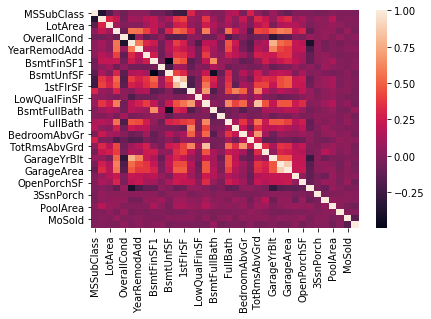

In [37]:
# удалил колонки Id и целевую переменную SalePrice, так как это не фичи
# по хитмап мне ничего не понятно, поэтому ниже я нашел скоррелированные пары
sns.heatmap(data.drop(['Id', 'SalePrice'], axis=1).corr())

In [39]:
# найти пары самых скоррелированных колонок
# я это просто загуглил
# пропустил первые 36 колонок, потому что это диагональ в матрице корреляции - корреляция колонки к колонке А равна 1
# и для примера взял топ 5 пар
data.drop(['Id', 'SalePrice'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False)[36:][:5]

GarageCars    GarageArea      0.882475
GarageArea    GarageCars      0.882475
TotRmsAbvGrd  GrLivArea       0.825489
GrLivArea     TotRmsAbvGrd    0.825489
TotalBsmtSF   1stFlrSF        0.819530
dtype: float64

In [42]:
# То есть выходит, что пара GarageCars и GarageArea могут мешать модели делать предсказания, 
# давай уберем одну из этих колонок и оставим колонку с большим вкладом

column_A = 'GarageCars'
column_B = 'GarageArea'

# X_A - все фичи, кроме A
# X_B - все фичи, кроме В

model = LinearRegression()
metrics_without_A = cross_val_score(model, 
                                    X = data.drop(['SalePrice', 'Id', column_A ], axis=1).to_numpy(), 
                                    y = data['SalePrice'].to_numpy(), 
                                    cv = 21, # это сколько раз нужно посчитать
                                    n_jobs = 4, # параллельно на 4 ядра CPU
                                    scoring='r2')

In [43]:
# получил такой array
metrics_without_A

array([ 0.86765861,  0.79700353,  0.85662185,  0.85040645,  0.88937989,
        0.87526277,  0.8522576 ,  0.59039643,  0.8989565 ,  0.78844489,
        0.8854049 ,  0.80800231,  0.7970408 ,  0.83379928,  0.88059095,
        0.75436409,  0.69714012,  0.81606311, -0.52953672,  0.83349023,
        0.80017445])

In [44]:
# делаю аналогично для колонки В
model = LinearRegression()
metrics_without_B = cross_val_score(model, 
                                    X = data.drop(['SalePrice', 'Id', column_B ], axis=1).to_numpy(), 
                                    y = data['SalePrice'].to_numpy(), 
                                    cv = 21, # это сколько раз нужно посчитать
                                    n_jobs = 4, # параллельно на 4 ядра CPU
                                    scoring='r2')

In [45]:
metrics_without_B

array([ 0.86238445,  0.79641014,  0.85551214,  0.85719853,  0.89063898,
        0.87101608,  0.85322873,  0.58514003,  0.90295979,  0.78928199,
        0.88687119,  0.79883182,  0.79588036,  0.81862473,  0.88369171,
        0.75933677,  0.70148541,  0.81399305, -0.4724277 ,  0.84243054,
        0.81535044])

In [46]:
# так как это numpy array, то можно легко найти поэлементную разницу
diff = metrics_without_A - metrics_without_B
diff
# получается где-то лучше, где-то хуже (смотри на знак)
# надо доказать, что есть значимое отличие от нуля

array([ 0.00527416,  0.00059339,  0.00110971, -0.00679208, -0.00125909,
        0.00424669, -0.00097113,  0.0052564 , -0.00400329, -0.0008371 ,
       -0.00146629,  0.00917049,  0.00116045,  0.01517455, -0.00310076,
       -0.00497267, -0.00434529,  0.00207006, -0.05710902, -0.00894031,
       -0.01517599])

In [52]:
# вот теория
# https://www.itl.nist.gov/div898/handbook/eda/section3/eda352.htm
# посчитаем доверительный интервал с уровнем уверенности 98% 
# Наша нулевая гиппотеза - результаты одинаковые
# Альтернативная - без одной из колонок лучше
# Если 0 НЕ будет входить в полученный интервал, то мы можем отбросить 
# нулевую гиппотезу с p-value = 2% 
# Если входит, то ничего нельзя сказать точно

from scipy.stats import sem,t

def confidence_interval(vector:np.array, confidence:float=0.98):
    """Calculate confidence interval."""
    m, se = np.mean(vector), sem(vector)
    h = se*t._ppf((1+confidence)/2., len(vector)-1)
    return m-h, m+h

confidence_interval(diff)

(-0.010781639905188801, 0.0045990544022645585)

In [ ]:
# 0 входит в наш интервал, значит нельзя сказать, что лучше без колонки А, чем В и наоборот. 
# посчитай аналогичным способом лучше ли вообще без этих колонок, чем с обеими